# Setup

In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy import stats

dl = DataLib("SignalData")
plt.style.use("seaborn")

In [2]:
# Pull all the necessary dataframes to avoid duplicate code. 
bri = dl.pull("BondRetIdx/LocalFX")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
EquityPrices = dl.pull("EquityPrices")
M1 = dl.pull("M1/inUSD")
M2 = dl.pull("M2/inUSD")
M3 = dl.pull("M3/inUSD")
CurrAcctNom = dl.pull("CurrAcctNom/inUSD")
CurrAcctPctGDP = dl.pull("CurrAcctPctGDP")
nGDP = dl.pull("GDP/Nominal")
rGDP = dl.pull("GDP/Real")
nFxTrdWts = dl.pull("fxTrdWts/Nominal")
rFxTrdWts = dl.pull("fxTrdWts/Real")
fxVsUSD = dl.pull("fxVsUSD")
core_cpi = dl.pull("CoreCPI/SA")
rfRates = dl.pull("RiskfreeRates")

In [3]:
# Constants. 
WORKDAYS_IN_MONTH=21
WORKDAYS_IN_YEAR=261
QUARTERS_IN_YEAR=4
COUNTRIES=[
    'USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU'
]

# Utility functions

In [15]:
def get_sharpe(country, prices): 
    
    risk_adjusted_returns = get_risk_adjusted_returns(prices)
    returns = risk_adjusted_returns
    gmean = stats.gmean((1 + returns[country]).dropna())
    annualized_return = (gmean ** 261) - 1
    risk = returns[country].std() * np.sqrt(261)
    
    return annualized_return/risk

def get_risk_adjusted_returns(prices):

    # Convert from monthly to daily rf rates.
    series = rfRates / 100
    series = series.resample('B').ffill()
    series = (series + 1) ** (1 / WORKDAYS_IN_YEAR) - 1
    series = series.loc[prices.index]
    
    # Convert this series to a dataframe.
    rf_rates = prices.copy()
    for country in rf_rates.columns.values: 
        rf_rates[country] = series
        
    # Subtract the rates from the change in bond returns. 
    return EquityPrices.pct_change() - rf_rates

# Equity Performance

First let's get the Sharpes for every country for a long-only strategy. 

In [16]:
for country in COUNTRIES: 
    print('{} long-only sharpe:'.format(country), "{:.2f}".format(get_sharpe(country, EquityPrices)))

USA long-only sharpe: 0.25
AUS long-only sharpe: 0.12
JPN long-only sharpe: -0.04
CAN long-only sharpe: 0.10
CHE long-only sharpe: 0.15
GBR long-only sharpe: 0.12
ESP long-only sharpe: 0.11
FRA long-only sharpe: 0.13
ITA long-only sharpe: 0.09
DEU long-only sharpe: 0.09


Let's see how the Sharpes change for every 10 year window from 1980 onwards. 

In [27]:
sharpes_10yr = []
for year in range(1980, 2020): 
    prices = EquityPrices[(EquityPrices.index >= year) \
                          & (EquityPrices.index < year+10)]
    sharpes_10yr.append(get_sharpe(country, prices))

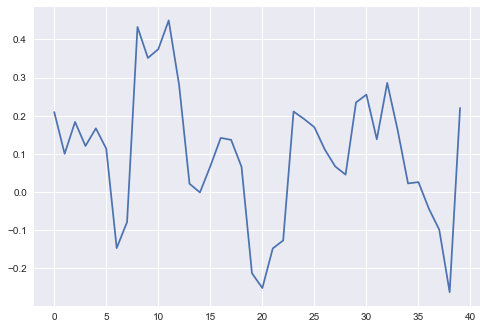

In [30]:
plt.plot(sharpes_10yr)